In [1]:
import sys
import os
import src.analyze as analyze
import src.stats_utils as stats_utils
import src.mixtures as mixtures
import src.better_optimiation as bopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import src.EM as EM
from src.EM import (
    compute_estimate,
    compute_estimate_stable,
    compute_p_at_ks,
    compute_estimates_better_mixture,
)
import src.better_em as BEM
import heapq
import src.bem_geometric as bemg
from src.bem_geometric import (
    compute_estimates_better_three_param_geometric,
    compute_estimates_three_param,
)

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set model and number of samples

In [2]:
model_name = "Pythia 70M"  # ['Pythia 12B', 'Pythia 160M', 'Pythia 1B', 'Pythia 2.8B', 'Pythia 410M', 'Pythia 6.9B', 'Pythia 70M']
samples = 50
# define the ks that we will try to predict
ks = np.array(np.logspace(np.log10(50), np.log10(10000), num=100))

Load all data for monkeys power laws

In [3]:
# get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

# this tells us whether each attempt was a success or failure -- I don't think it adds any
# value given that the attempts were independent
individual_data = analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()


Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


Number of total samples is missing-- fill this in

In [4]:
# label the number of total samples and compute the number of correct attempts for each problem
data["Num. Samples Total"] = 10000
data["Num. Samples Correct"] = data["Score"] * data["Num. Samples Total"]
data = data[data["Scaling Parameter"] == 1]

Filter for only the preferred model

In [5]:
pythia12_math = data[(data["Model"] == model_name)]

Collect a subset of the data that we use as the training set for prediction

In [6]:
model_ind = individual_data[
    (individual_data["Benchmark"] == "MATH") & (individual_data["Model"] == model_name)
]
model_ind = model_ind[model_ind["Attempt Idx"] <= samples]
model_ind["Num. Samples Correct"] = model_ind.groupby("Problem Idx")["Score"].transform(
    "sum"
)
model_ind["Num. Samples Total"] = samples
smaller_pythia12_math = model_ind

Fit all methods that don't involve mixtures

In [7]:
smaller_beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_2_params_stable = bopt.fit_beta_binomial_two_parameters_stable(
    smaller_pythia12_math
)
# smaller_beta_3_params = analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(smaller_pythia12_math)
smaller_beta_3_params_stable = bopt.fit_beta_binomial_three_parameters_stable(
    smaller_pythia12_math
)
smaller_beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)

In [8]:
smaller_beta_3_params_stable

alpha                    0.482383
beta                   100.000000
loc                      0.000000
scale                    0.100000
neg_log_likelihood    1303.297702
aic                   2612.595403
bic                   2632.887563
Power Law Exponent       0.482383
dtype: float64

Compute the original OpenAI method

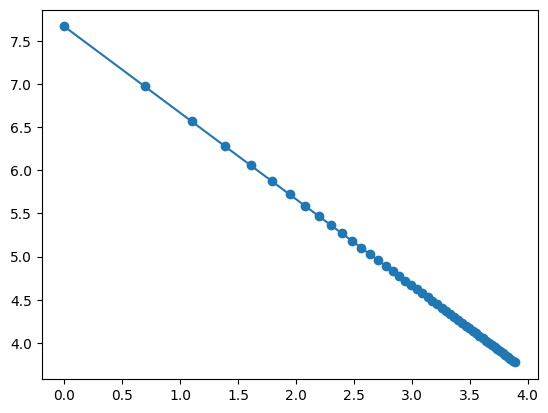

In [9]:
# original estimator
ks_fit = np.array([i for i in range(1, samples)])
pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(
    smaller_pythia12_math, ks_fit
)
pass_at_ks = pass_at_ks.groupby("Scaling Parameter")["Score"].mean()
model = LinearRegression(fit_intercept=True)
model.fit(np.log(ks_fit).reshape(-1, 1), -np.log(pass_at_ks))
plt.scatter(np.log(ks_fit), -np.log(pass_at_ks))
plt.plot(np.log(ks_fit), model.predict(np.log(ks_fit).reshape(-1, 1)))

Compute beta-binomial mixture parameters

In [10]:
n_distr = 1
beta_mixture = BEM.beta_binom_mixture(
    n_distr=n_distr,
    num_successes=smaller_pythia12_math["Num. Samples Correct"],
    num_trials=smaller_pythia12_math["Num. Samples Total"],
)
beta_mixture_params = beta_mixture.fit_mixture()
# beta_mixture_params = EM.fit_beta_binomial_mixture_em(smaller_pythia12_math['Num. Samples Total'], smaller_pythia12_math['Num. Samples Correct'], n_distr)

0: nll: 765.0428256396581
0: nll: 726.6943024250025
0: nll: 726.6923091022477
0: nll: 726.6923088927172
0: nll: 726.6923072842502
0: nll: 726.6923051105636
0: nll: 726.6923047183269
0: nll: 726.6923038444418
0: nll: 726.6923030811597
0: nll: 726.6923019655195
0: nll: 726.6922989640364
0: nll: 726.6922959794726
0: nll: 726.692292606495
0: nll: 726.6922922593125
0: nll: 726.6922919484301
0: nll: 726.6922913926408
0: nll: 726.6922673436227
0: nll: 726.6922670555317
0: nll: 726.692265436003
0: nll: 726.6922620329524
0: nll: 726.6922614430172
0: nll: 726.6922600884158
0: nll: 726.692259489019
0: nll: 726.6922591591481
0: nll: 726.6922591498655
0: nll: 726.6922570148665
0: nll: 726.6922562196299
0: nll: 726.6922552054552
0: nll: 726.6922491512275
0: nll: 726.6922465856283
0: nll: 726.6922448297407
0: nll: 726.6922428676111
0: nll: 726.6922427237887
0: nll: 726.6922427236125
0: nll: 726.6922427236125
0: nll: 726.6922427236125
0: nll: 726.6922427236125
0: nll: 726.6922427236125
0: nll: 726.692

Sample efficiently by always sampling the question with the lowest success probability so far

In [11]:
individual_data_model = individual_data[(individual_data["Model"] == model_name)]

heap = []
heapq.heapify(heap)
budget = samples * len(pythia12_math)
results = []
for ele in individual_data_model["Problem Idx"].unique():
    heapq.heappush(heap, (0, ele))
total_samples = 0
while total_samples < budget:
    total_samples += 1
    attempts, index = heapq.heappop(heap)
    attempt_index = attempts + 1

    # Check if this attempt exists
    filtered_data = individual_data_model[
        (individual_data_model["Problem Idx"] == index)
        & (individual_data_model["Attempt Idx"] == attempt_index)
    ]

    if filtered_data.empty:
        continue  # Skip if no data for this attempt

    score = filtered_data["Score"].iloc[0]
    attempts += 1

    if score == 0:
        heapq.heappush(heap, (attempts, index))  # Fixed: use 'index' not 'ele'
    else:
        results.append(
            {
                "Problem Idx": index,
                "Num. Samples Total": attempts,
                "Num. Samples Correct": 1,
            }
        )
while heap:
    attempts, index = heapq.heappop(heap)
    results.append(
        {
            "Problem Idx": index,
            "Num. Samples Total": attempts,
            "Num. Samples Correct": 0,
        }
    )
efficient_data = pd.DataFrame(results)

Fit geometric mixture

In [12]:
# beta 2 geometric
n_distr = 1
geom_mix = bemg.beta_geometric_mixture(
    n_distr=n_distr,
    num_successes=efficient_data["Num. Samples Correct"],
    num_trials=efficient_data["Num. Samples Total"],
)
geom_params = geom_mix.fit_mixture()
# beta 3 geometric
smaller_beta_3_params_geometric_stable = bopt.fit_beta_binomial_three_parameters_stable(
    efficient_data
)

0: nll: 26.572272621442018
0: nll: 26.572272053938054
0: nll: 26.572271459322835
0: nll: 26.572270518763915
0: nll: 26.572269656281723
0: nll: 26.57226879444324
0: nll: 26.572267829373796
0: nll: 26.57226689007352
0: nll: 26.572265754585285
0: nll: 26.572264653238715
0: nll: 26.57226368623264
0: nll: 26.57226277789994
0: nll: 26.57226151519267
0: nll: 26.57226029588204
0: nll: 26.57225913221925
0: nll: 26.572258093269138
0: nll: 26.572257164000114
0: nll: 26.572256260613646
0: nll: 26.572255343309166
0: nll: 26.572254433824227
0: nll: 26.57225337688195
0: nll: 26.572252337303897
0: nll: 26.572251399863653
0: nll: 26.572250494996904
0: nll: 26.572249641160855
0: nll: 26.572248807185304
0: nll: 26.572247955193486
0: nll: 26.57224708402659
0: nll: 26.572246206134906
0: nll: 26.572245301633615
0: nll: 26.572244571139514
0: nll: 26.57224375864056
0: nll: 26.57224292477824
0: nll: 26.572242006050118
0: nll: 26.572241227555025
0: nll: 26.57224043712371
0: nll: 26.572239714801206
0: nll: 26.57

Compute p@k estimates

In [13]:
pass_at_ks = compute_p_at_ks(pythia12_math, ks)

Compute estimates for all methods

In [14]:
# openai regression predictions
X = ks.reshape(-1, 1)
regression_predictions = np.exp(-model.predict(np.log(X)))
# beta discretized estimates
beta_estimates = [compute_estimate(smaller_beta_3_discretized_params, k) for k in ks]
# 2-param binomial mixture
mixture_estimates = [
    compute_estimates_better_mixture(
        smaller_pythia12_math, beta_mixture_params, k, n_distr
    )
    for k in ks
]
# 3-param binomial
beta_3_stable_estimates_better = [
    compute_estimates_three_param(
        smaller_pythia12_math, smaller_beta_3_params_stable, k
    )
    for k in ks
]
# 3-param geometric
three_param_geom_estimates = [
    bemg.compute_estimates_better_three_param_geometric(
        efficient_data, smaller_beta_3_params_geometric_stable, k
    )
    for k in ks
]
# 2-param geometric
geom_correct_estimates = [
    bemg.compute_estimates_better_mixture_geometric(
        efficient_data, geom_params, k, n_distr
    )
    for k in ks
]

0.9768236358793584
0.9755964680883388
0.9743069155149205
0.9729520846554431
0.97152897735071
0.970034490202488
0.9684654143923664
0.9668184359525178
0.9650901365408558
0.9632769947759087
0.9613753881893468
0.9593815958564577
0.9572918017668527
0.9551020989992396
0.9528084947650909
0.9504069163863735
0.9478932182720634
0.9452631899568135
0.942512565262759
0.939637032641883
0.9366322467514935
0.9334938413090622
0.9302174432648
0.926798688320802
0.9232332378142755
0.9195167969692066
0.9156451345057794
0.911614103579928
0.9074196640066255
0.9030579056999789
0.8985250732410525
0.8938175914608046
0.888932091900872
0.8838654399895144
0.8786147627442946
0.8731774767874698
0.8675513164352145
0.8617343615982862
0.8557250652102464
0.8495222798805947
0.8431252834548437
0.8365338031524043
0.8297480379468175
0.8227686788519949
0.8155969267832318
0.8082345076732723
0.8006836845418719
0.7929472662422625
0.7850286126395655
0.7769316360142462
0.7686607985276784
0.7602211056360696
0.7516180953925204
0.74

Make a graph of the fits

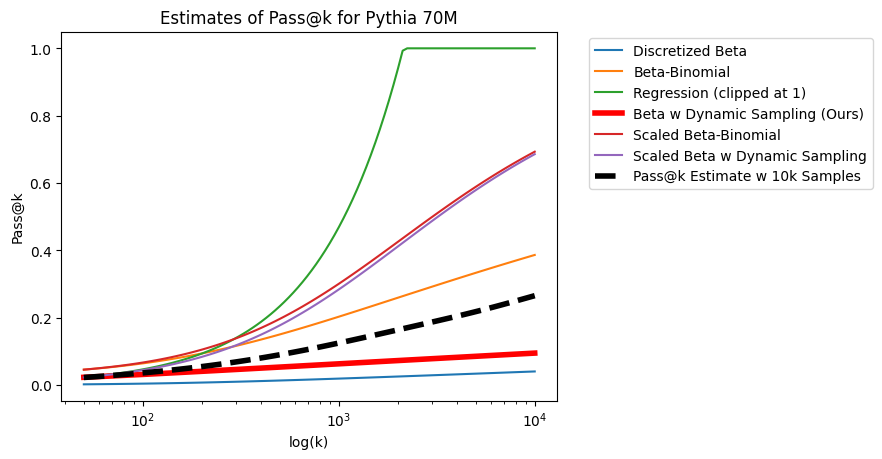

In [15]:
plt.plot(ks, beta_estimates, label="Discretized Beta")
plt.plot(ks, mixture_estimates, label="Beta-Binomial")
plt.plot(ks, np.clip(regression_predictions, 0, 1), label="Regression (clipped at 1)")
plt.plot(
    ks,
    np.clip(geom_correct_estimates, 0, 1),
    label="Beta w Dynamic Sampling (Ours)",
    linewidth=4,
    color="red",
    linestyle="-",
    markeredgecolor="darkred",
)
plt.plot(ks, beta_3_stable_estimates_better, label="Scaled Beta-Binomial")
plt.plot(ks, three_param_geom_estimates, label="Scaled Beta w Dynamic Sampling")
plt.plot(
    ks,
    pass_at_ks,
    label="Pass@k Estimate w 10k Samples",
    linewidth=4,
    color="black",
    linestyle="dashed",
)
plt.title(f"Estimates of Pass@k for {model_name}")
plt.ylabel("Pass@k")
plt.xlabel("log(k)")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")